In [45]:
import sys
sys.path.append("..")
from src.simulations import SurfaceCodeSim
from src.graph_representation import get_3D_graph
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import KNNGraph
from torch_geometric.nn import knn_graph
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
from icecream import ic

In [3]:
def visualise_graph(graph, code_sz, reps):
    x = graph.x
    edge_index = graph.edge_index
    edge_attr = graph.edge_attr
    
    # trim away unneccesary information in node features
    x = x[:, 2:]
    
    # get edge coordinates
    edges = np.array([(x[u], x[v]) for u, v in edge_index.T])
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection="3d")
    for edge in edges:
        ax.plot(*edge.T, c="b")
    
    ax.scatter(*x.T, s=100)
    ax.set_xlim([-1, code_sz + 1])
    ax.set_ylim([-1, code_sz + 1])
    ax.set_zlim([-1, reps + 1])
    
    ax.set_xticks(range(0, code_sz + 1))
    ax.set_yticks(range(0, code_sz + 1))
    ax.set_zticks(range(0, code_sz + 1))

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Time")
    ax.set_box_aspect(aspect=None, zoom=0.8)
    ax.set_title(f"Syndrome graph for d={code_sz}")
    fig.tight_layout()

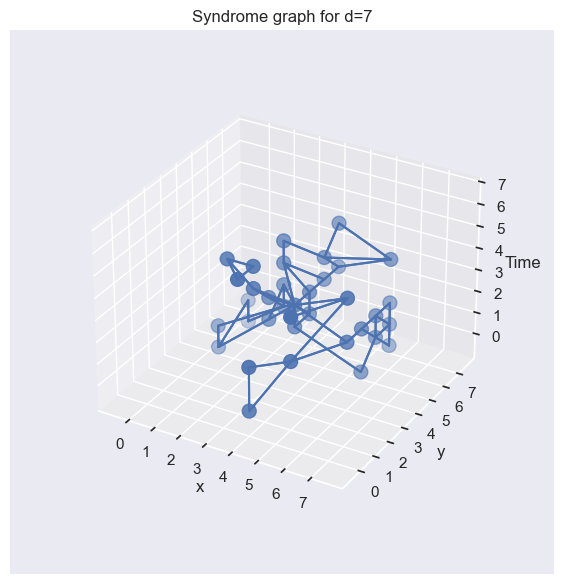

In [4]:
seed = 11
n_graphs = 10
code_sz = 7
reps = 5
p = 5e-3
m_nearest_nodes = 2

sim = SurfaceCodeSim(reps, code_sz, p, n_graphs, seed=seed)
syndromes, flips, n_identities = sim.generate_syndromes()
graphs = []
for syndrome, flip in zip(syndromes, flips):
    x, edge_index, edge_attr, y = get_3D_graph(
        syndrome_3D=syndrome,
        target=flip,
        m_nearest_nodes=m_nearest_nodes,
        power=2.0,
    )
    graphs.append(Data(x, edge_index, edge_attr, y, pos=x[:, 2:]))

visualise_graph(graphs[0], code_sz, reps)

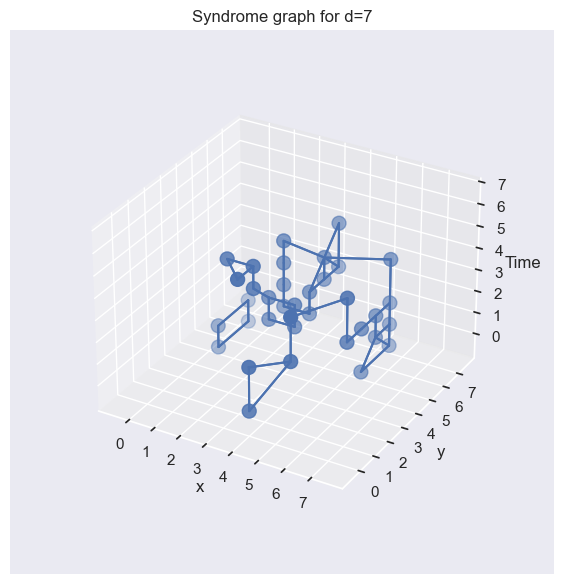

In [5]:
m_nearest_nodes = None
transform = KNNGraph(k=2, force_undirected=True, flow="target_to_source")

sim = SurfaceCodeSim(reps, code_sz, p, n_graphs, seed=seed)
syndromes, flips, n_identities = sim.generate_syndromes()
graphs = []
for syndrome, flip in zip(syndromes, flips):
    x, edge_index, edge_attr, y = get_3D_graph(
        syndrome_3D=syndrome,
        target=flip,
        m_nearest_nodes=m_nearest_nodes,
        power=2.0,
    )
    data = Data(x, edge_index, edge_attr, y, pos=x[:, 2:])
    data = transform(data)
    graphs.append(data)

visualise_graph(graphs[0], code_sz, reps)

In [57]:
sim = SurfaceCodeSim(reps, code_sz, p, n_graphs, seed=seed)
syndromes, flips, n_identities = sim.generate_syndromes()

def get_batch_of_graphs(syndromes, m_nearest_nodes):
    
    syndromes = syndromes.astype(np.float32)
    defect_inds = np.nonzero(syndromes)
    defects = syndromes[defect_inds]

    defect_inds = np.transpose(np.array(defect_inds))

    x_defects = defects == 1
    z_defects = defects == 3

    node_features = np.zeros((defects.shape[0], 6), dtype=np.float32)

    node_features[x_defects, 0] = 1
    node_features[x_defects, 2:] = defect_inds[x_defects, ...]
    node_features[z_defects, 1] = 1
    node_features[z_defects, 2:] = defect_inds[z_defects, ...]

    node_features.max(axis=0)
    x_cols = [0, 1, 3, 4, 5]
    batch_col = 2

    x = torch.tensor(node_features[:, x_cols])
    batch_labels = torch.tensor(node_features[:, batch_col])
    pos = x[:, 2:]
    
    # get edge indices
    edge_index = knn_graph(pos, m_nearest_nodes, batch=batch_labels)
    
    # find edge attributes
    x_dist = torch.abs(pos[:, 1, None].T - pos[:, 1, None])
    y_dist = torch.abs(pos[:, 0, None].T - pos[:, 0, None])
    t_dist = torch.abs(pos[:, 2, None].T - pos[:, 2, None])
    
    stack = torch.stack((x_dist, y_dist, t_dist))
    sup_norm, _ = torch.max(stack, dim=0)
    sup_norm = 1.0 / sup_norm ** 2
    edge_attr = sup_norm[*edge_index].reshape(edge_index.shape[1], 1)

    return x, edge_index, edge_attr, batch_labels

x, edge_index, edge_attr, batch_labels = get_batch_of_graphs(syndromes, 3)



ic| x.dtype: torch.float32
ic| edge_index.dtype: torch.int64
ic| edge_attr.dtype: torch.float32
ic| batch_labels.dtype: torch.float32


torch.float32